In [1]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 📁 Paths
train_df = pd.read_csv("C:/Users/anves/Documents/desktop/shl/dataset/train.csv")
test_df = pd.read_csv("C:/Users/anves/Documents/desktop/shl/dataset/test.csv")
audio_dir = "C:/Users/anves/Documents/desktop/shl/dataset/audios_train"


In [2]:
# Extracts sequence features for Bi-LSTM and static features for XGBoost/SVM
def extract_features(audio_path, use_sequence=False):
    y, sr = librosa.load(audio_path, sr=None)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch = librosa.yin(y, fmin=50, fmax=300)
    rhythm = librosa.beat.tempo(y=y, sr=sr)

    if use_sequence:
        return mfcc.T
    else:
        mfcc_mean = np.mean(mfcc, axis=1)
        pitch_mean = np.mean(pitch)
        rhythm_val = rhythm[0] if len(rhythm) > 0 else 0
        return np.concatenate([mfcc_mean, [pitch_mean, rhythm_val]])


In [3]:
X_seq = []
X_static = []
y = []

In [4]:
# Load features


for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    path = os.path.join(audio_dir, row["filename"])
    X_seq.append(extract_features(path, use_sequence=True))
    X_static.append(extract_features(path, use_sequence=False))
    y.append(row["label"])

# Padding for sequence data
from torch.nn.utils.rnn import pad_sequence

X_seq_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in X_seq], batch_first=True)
X_static = np.array(X_static)
y = np.array(y)


  0%|                                                                                          | 0/444 [00:00<?, ?it/s]C:\Users\anves\AppData\Local\Temp\ipykernel_4240\3612175078.py:7: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  rhythm = librosa.beat.tempo(y=y, sr=sr)
100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [11:52<00:00,  1.60s/it]


In [5]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64, output_dim=6):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(out)


In [6]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_bilstm_model(X_seq, y, epochs=10):
    model = BiLSTMModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    dataset = AudioDataset(X_seq, y)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model


In [13]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from xgboost import XGBRegressor
import numpy as np
import torch

kf = KFold(n_splits=5, shuffle=True, random_state=42)

meta_features = []
meta_labels = []


In [14]:
for train_idx, val_idx in kf.split(X_static):
    # Split data
    X_train_seq, X_val_seq = X_seq_padded[train_idx], X_seq_padded[val_idx]
    X_train_static, X_val_static = X_static[train_idx], X_static[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


In [15]:
    bilstm_model = train_bilstm_model(X_train_seq, y_train, epochs=5)
    bilstm_model.eval()
    with torch.no_grad():
        bilstm_preds = bilstm_model(X_val_seq).numpy()  # shape: (num_samples, 1)


Epoch 1, Loss: 39.2979
Epoch 2, Loss: 34.3236
Epoch 3, Loss: 32.5340
Epoch 4, Loss: 32.1749
Epoch 5, Loss: 31.7493


In [16]:
    svm_model = SVC(probability=True)
    y_train_class = y_train.round().astype(int)  # Convert regression labels to class labels
    svm_model.fit(X_train_static, y_train_class)
    svm_preds = svm_model.predict_proba(X_val_static)  # shape: (num_samples, num_classes)


In [17]:
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train_static, y_train)
    xgb_preds = xgb_model.predict(X_val_static)  # shape: (num_samples,)
    xgb_preds = xgb_preds.reshape(-1, 1)  # reshape for stacking


In [18]:
    stacked = np.hstack([bilstm_preds, svm_preds, xgb_preds])
    meta_features.append(stacked)
    meta_labels.append(y_val)


In [19]:
meta_X = np.vstack(meta_features)
meta_y = np.concatenate(meta_labels)


In [37]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

# Choose one depending on preference
meta_model = Ridge()  # Linear regression model
# meta_model = LGBMRegressor()  # Gradient boosting regression model

meta_model.fit(meta_X, meta_y)


Ridge()

In [24]:
# Assuming X_val_seq is a torch tensor with shape [batch_size, time_steps, features]
# and bilstm_model returns a tensor of shape [batch_size, num_classes] or regression scores

# If Bi-LSTM is for regression
bilstm_model.eval()
with torch.no_grad():
    bilstm_output = bilstm_model(X_val_seq)
    preds_bilstm = bilstm_output.squeeze().cpu().numpy()  # for regression

# For SVM and XGBoost
preds_svm = svm_model.predict(X_val_static)
preds_xgb = xgb_model.predict(X_val_static)

# For the meta-model (regression version)
preds_meta = meta_model.predict(meta_X)


In [33]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    import numpy as np
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        mean_absolute_error, mean_squared_error
    )
    from scipy.stats import pearsonr
    import matplotlib.pyplot as plt

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Convert probabilities/logits to class indices
    if y_pred.ndim == 2:
        y_pred = np.argmax(y_pred, axis=1)

    # If predictions are floats (e.g., regression-style), round them
    if y_pred.dtype.kind in {'f'}:
        y_pred = np.round(y_pred).astype(int)

    # If labels are floats (possible in regression targets), round them too
    if y_true.dtype.kind in {'f'}:
        y_true = np.round(y_true).astype(int)

    # Now safe to compute classification metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    corr, _ = pearsonr(y_true, y_pred)

    print(f"\n📊 Evaluation for {model_name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"MAE:       {mae:.4f}")
    print(f"MSE:       {mse:.4f}")
    print(f"Pearson:   {corr:.4f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
    plt.title(f"{model_name}: Expected vs Predicted")
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.grid(True)
    plt.legend()
    plt.show()



📊 Evaluation for Bi-LSTM
Accuracy:  0.2955
Precision: 0.4265
Recall:    0.2955
F1-score:  0.2532
MAE:       1.2614
MSE:       2.7614
Pearson:   0.1081


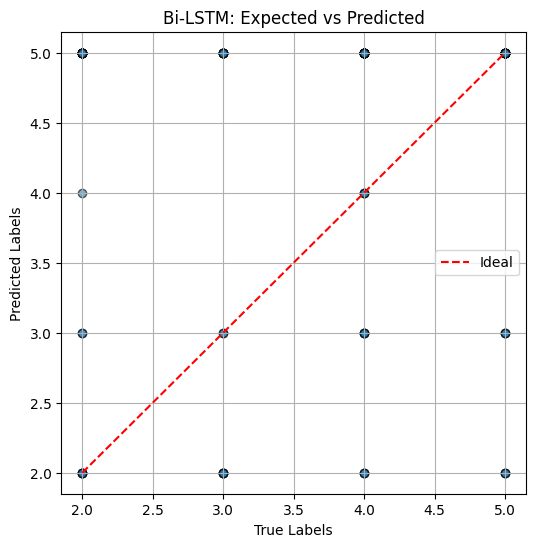


📊 Evaluation for SVM
Accuracy:  0.3295
Precision: 0.1086
Recall:    0.3295
F1-score:  0.1634
MAE:       0.9205
MSE:       1.4205
Pearson:   nan


C:\Users\anves\AppData\Local\Temp\ipykernel_4240\1511382633.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_true, y_pred)


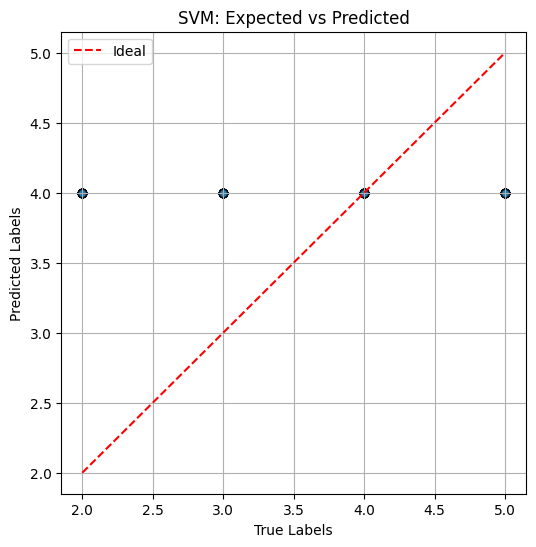


📊 Evaluation for XGBoost
Accuracy:  0.3977
Precision: 0.4762
Recall:    0.3977
F1-score:  0.3804
MAE:       0.7500
MSE:       1.0682
Pearson:   0.4591


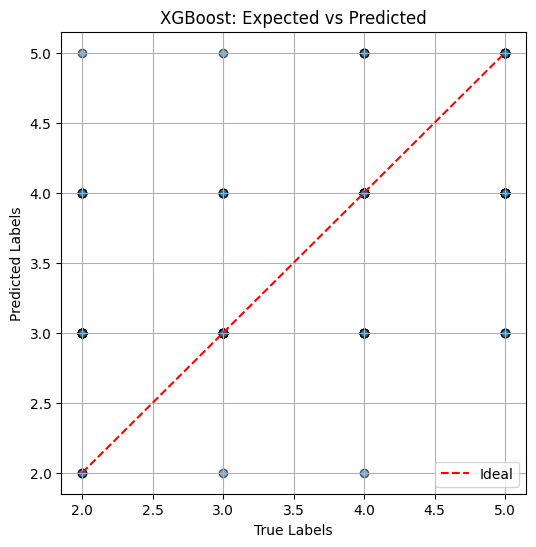


📊 Evaluation for Meta-Model
Accuracy:  0.3523
Precision: 0.5493
Recall:    0.3523
F1-score:  0.2842
MAE:       0.7500
MSE:       0.9545
Pearson:   0.4858


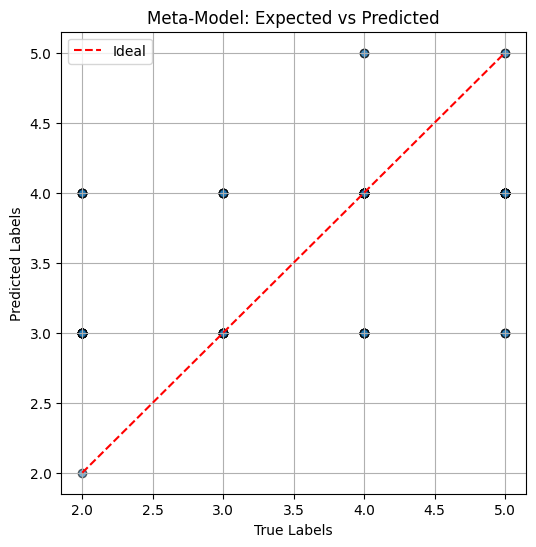

In [35]:
evaluate_model(y_val, preds_bilstm, "Bi-LSTM")
evaluate_model(y_val, preds_svm, "SVM")
evaluate_model(y_val, preds_xgb, "XGBoost")
evaluate_model(meta_y, preds_meta, "Meta-Model")


In [ ]:
import numpy as np

# Save the arrays to disk
np.save('X_seq.npy', X_seq)
np.save('X_meta.npy', X_meta)
np.save('y.npy', y)
